# WHEN WAS THE GOLDEN AGE OF VIDEO GAMES?

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)z

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The case study was done in PostgreSQL, so I will use the python libraries to interact with the SQL database

In [ ]:
import sqlite3

# Read the CSV file
df = pd.read_csv("/kaggle/input/videogamedata/game_sales_data.csv", encoding="latin-1")

# Create a conection to a SQLite database in memory
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
# Save the DataFrame in the SQLite database and add a table name
df.to_sql('database', conn, index=False)

# Commit changes
conn.commit()

In [ ]:
# Create game_sales table
crear_tabla1_sql = """
CREATE TABLE game_sales (
    rank INTEGER PRIMARY KEY,
    name TEXT,
    platform TEXT,
    publisher TEXT,
    developer TEXT,
    total_shipped NUMERIC,
    year INTEGER
)
"""
conn.execute(crear_tabla1_sql)
conn.commit()

# Create reviews table
crear_tabla2_sql = """
CREATE TABLE reviews (
    rank INTEGER PRIMARY KEY,
    name TEXT,
    critic_score NUMERIC,
    user_score NUMERIC
)
"""
conn.execute(crear_tabla2_sql)
conn.commit()

In [ ]:
# Transfer data to game_sales table columns
conn.execute("INSERT INTO game_sales (name,platform,publisher,developer,total_shipped,year) SELECT Name,Platform,Publisher,Developer,Total_Shipped,Year FROM database")

# Transfer data to reviews table columns
conn.execute("INSERT INTO reviews (name,critic_score,user_score) SELECT Name,Critic_Score,User_Score FROM database")

conn.commit()

## Data info

Video games are big business: the global gaming market is projected to be worth more than $300 billion by 2027 according to Mordor Intelligence. With so much money at stake, the major game publishers are hugely incentivized to create the next big hit. But are games getting better, or has the golden age of video games already passed?

In this project, we'll explore sales of video games created between 1977 and 2020. We'll compare a dataset on game sales with critic and user reviews to determine whether or not video games have improved as the gaming market has grown.

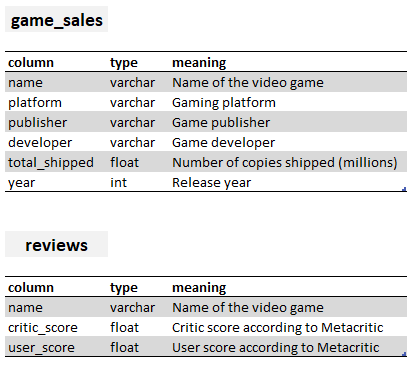

## 1. The ten best-selling video games

Select all information for the top ten best-selling games and order the results from best-selling game down to tenth best-selling


In [ ]:
consulta_sql = """SELECT *
FROM game_sales
ORDER BY total_shipped DESC
LIMIT 10;"""
resultado = pd.read_sql_query(consulta_sql, conn)

print(resultado)

**The best-selling video games were released between 1985 to 2017!**

## 2. Missing review scores

Select a count of the number of games where both critic_score and user_score are null

In [ ]:
consulta_sql = """SELECT COUNT(s.name)
FROM game_sales as s
LEFT JOIN reviews as r 
ON s.name = r.name
WHERE r.critic_score IS NULL AND r.user_score IS NULL;"""

resultado = pd.read_sql_query(consulta_sql, conn)
print(resultado)

## 3. Years that video game critics loved

The missing reviews data is a good thing to keep in mind as we move on to evaluating results from more sophisticated queries. There are lots of ways to measure the best years for video games! Let's start with what the critics think.

Select release year and average critic score for each year,group by release year and order the data from highest to lowest avg_critic_score and limit to 10 results

In [ ]:
consulta_sql = """SELECT s.year AS year, ROUND(AVG(r.critic_score),2) AS avg_critic_score
FROM game_sales as s
INNER JOIN reviews as r 
ON s.name = r.name
WHERE r.critic_score IS NOT NULL
GROUP BY year
ORDER BY avg_critic_score DESC
LIMIT 10;"""

resultado = pd.read_sql_query(consulta_sql, conn)
resultado.to_sql('top_critic_years', conn, index=False)
print(resultado)

**The range of great years according to critic reviews goes from 1984 until 2020.**

## 4. Was 1984 really that great?
Some of those avg_critic_score values look like suspiciously round numbers for averages. The value for 1984 looks especially fishy. Maybe there weren't a lot of video games in our dataset that were released in certain years.

Let's update our query and find out whether 1984 really was such a great year for video games.

In [ ]:
consulta_sql = """SELECT g.year, COUNT(g.name) AS num_games, ROUND(AVG(r.critic_score),2) AS avg_critic_score
FROM game_sales g
INNER JOIN reviews r
ON g.name = r.name
WHERE r.critic_score IS NOT NULL
GROUP BY g.year
HAVING COUNT(g.name) > 4
ORDER BY avg_critic_score DESC
LIMIT 10;"""

resultado = pd.read_sql_query(consulta_sql, conn)
resultado.to_sql('top_critic_years_more_than_four_games', conn, index=False)
print(resultado)

## 5. Years that dropped off the critics' favorites list
The num_games column convinces us that our new list of the critics' top games reflects years that had quite a few well-reviewed games rather than just one or two hits. But which years dropped off the list due to having four or fewer reviewed games? Let's identify them so that someday we can track down more game reviews for those years and determine whether they might rightfully be considered as excellent years for video game releases!

It's time to brush off your set theory skills. Select the year and avg_critic_score for those years that dropped off the list of critic favorites and order the results from highest to lowest avg_critic_score


In [ ]:
consulta_sql = """SELECT t.year AS year, t.avg_critic_score
FROM top_critic_years as t
WHERE t.year NOT IN
    (SELECT f.year
    FROM top_critic_years_more_than_four_games as f);"""

resultado = pd.read_sql_query(consulta_sql, conn)

print(resultado)

## 6. Years video game players loved
Based on our work in the task above, it looks like the early 1980s might merit consideration as the golden age of video games based on critic_score alone, but we'd need to gather more games and reviews data to do further analysis.

Let's move on to looking at the opinions of another important group of people: players! To begin, let's create a query very similar to the one we used in previous taska, except this one will look at user_score averages by year rather than critic_score averages.

In [ ]:
consulta_sql = """SELECT s.year AS year, COUNT(s.name) AS num_games, ROUND(AVG(r.user_score),2) AS avg_user_score
FROM game_sales as s
INNER JOIN reviews as r 
ON s.name = r.name
GROUP BY year
HAVING COUNT(s.name) > 4
ORDER BY avg_user_score DESC
LIMIT 10;"""

resultado = pd.read_sql_query(consulta_sql, conn)
resultado.to_sql('top_user_years_more_than_four_games', conn, index=False)
print(resultado)

## 7. Years that both players and critics loved
Alright, we've got a list of the top ten years according to both critic reviews and user reviews. Are there any years that showed up on both tables? If so, those years would certainly be excellent ones!

Select the year results that appear on both tables:

In [ ]:
consulta_sql = """SELECT c.year
FROM top_critic_years_more_than_four_games AS c
INNER JOIN top_user_years_more_than_four_games AS u
ON c.year = u.year
LIMIT 10;"""

resultado = pd.read_sql_query(consulta_sql, conn)

print(resultado)

## 8. Sales in the best video game years
Looks like we've got two years that both users and critics agreed were in the top ten! There are many other ways of measuring what the best years for video games are, but let's stick with these years for now. We know that critics and players liked these years, but what about video game makers? Were sales good? Let's find out.

This time, we haven't saved the results from the previous task in a table for you. Instead, we'll use the query from the previous task as a subquery in this one! This is a great skill to have, as we don't always have write permissions on the database we are querying.

In [ ]:
consulta_sql = """WITH years_critic_user AS (
    SELECT c.year AS year_g, c.num_games, c.avg_critic_score
    FROM top_critic_years_more_than_four_games AS c
    INNER JOIN top_user_years_more_than_four_games AS u
    ON c.year = u.year
    )

SELECT a.year, SUM(a.total_shipped) AS total_games_sold
FROM game_sales AS a
RIGHT JOIN years_critic_user AS b 
ON a.year = b.year_g
GROUP BY a.year
ORDER BY total_games_sold DESC;"""

resultado = pd.read_sql_query(consulta_sql, conn)
print(resultado)

In [ ]:
conn.close()